In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import GRU, Input, Flatten, Dense, Dropout, Conv2D, MaxPool2D, Dot
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
import librosa
from IPython.display import Audio
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
import math
from tqdm import tqdm
from itertools import combinations
from tensorflow.keras.metrics import BinaryAccuracy
import random
import pickle



# Speaker Recognition

## Data Pre-Processing

Funtion generate_positive_samples_train, is defined to create positive samples for training, along with labels

Funtion generate_positive_samples_test, is defined to create negative samples for testing, along with labels

Funtion generate_negative_samples_train, is defined to create positive samples for training, along with labels

Funtion generate_negative_samples_test, is defined to create negative samples for testing, along with labels


### Data Loading

In [3]:
with open('trs.pkl', 'rb') as file:
    train_data  = pickle.load(file)

with open('tes.pkl', 'rb') as file:
    test_data = pickle.load(file)

### Dataset; Positive and Negative Sample Generation



In [4]:
def generate_positive_samples_train(data):
  dataset_TD = []
  dataset_FD = []

  labels = []
  combinations_list = list(combinations(range(10), 2))
  random.shuffle(combinations_list)
  for pair in combinations_list:
    data_1_TD = data[pair[0]]
    data_2_TD = data[pair[1]]
    dataset_TD.append([data_1_TD, data_2_TD])
    data_1_C_FD = librosa.stft(data_1_TD, n_fft=1024, hop_length=512)
    data_2_C_FD = librosa.stft(data_2_TD, n_fft=1024, hop_length=512)
    data_1_FD = np.abs(data_1_C_FD)
    data_2_FD = np.abs(data_2_C_FD)
    data_1_FD_t = np.transpose(data_1_FD)
    data_2_FD_t = np.transpose(data_2_FD)
    dataset_FD.append([data_1_FD_t, data_2_FD_t])
    labels.append('1')
  return dataset_TD, dataset_FD, labels

def generate_positive_samples_test(data):
    dataset_TD = []
    dataset_FD = []
    labels = []
    combinations_list = list(combinations(range(10), 2))
    random.shuffle(combinations_list)
    for pair in combinations_list:
      data_1_TD = data[pair[0]]
      data_2_TD = data[pair[1]]
      dataset_TD.append([data_1_TD, data_2_TD])
      data_1_C_FD = librosa.stft(data_1_TD, n_fft=1024, hop_length=512)
      data_2_C_FD = librosa.stft(data_2_TD, n_fft=1024, hop_length=512)
      data_1_FD = np.abs(data_1_C_FD)
      data_2_FD = np.abs(data_2_C_FD)
      data_1_FD_t = np.transpose(data_1_FD)
      data_2_FD_t = np.transpose(data_2_FD)
      dataset_FD.append([data_1_FD_t, data_2_FD_t])
      labels.append('1')
    return dataset_TD, dataset_FD, labels

def generate_negative_samples_train(data, all_data, speaker_num):
  dataset_TD = []
  dataset_FD = []
  labels = []

  speaker_1 = [random.randint(0, 9) for _ in range(45)]
  speaker_2 = [(random.choice([i for i in range(50) if i != speaker_num]), random.randint(0, 9)) for _ in range(45)]


  for i in range(45):
    data_1_TD = data[speaker_1[i]]
    data_2_TD = all_data[speaker_2[i][0]*10:(speaker_2[i][0]*10)+10][speaker_2[i][1]]
    dataset_TD.append([data_1_TD, data_2_TD])
    data_1_C_FD = librosa.stft(data_1_TD, n_fft=1024, hop_length=512)
    data_2_C_FD = librosa.stft(data_2_TD, n_fft=1024, hop_length=512)
    data_1_FD = np.abs(data_1_C_FD)
    data_2_FD = np.abs(data_2_C_FD)
    data_1_FD_t = np.transpose(data_1_FD)
    data_2_FD_t = np.transpose(data_2_FD)
    dataset_FD.append([data_1_FD_t, data_2_FD_t])
    labels.append('0')


  return dataset_TD, dataset_FD, labels

def generate_negative_samples_test(data, all_data, speaker_num):
  dataset_TD = []
  dataset_FD = []
  labels = []

  speaker_1 = [random.randint(0, 9) for _ in range(45)]
  speaker_2 = [(random.choice([i for i in range(20) if i != speaker_num]), random.randint(0, 9)) for _ in range(45)]


  for i in range(45):
    data_1_TD = data[speaker_1[i]]
    data_2_TD = all_data[speaker_2[i][0]*10:(speaker_2[i][0]*10)+10][speaker_2[i][1]]
    dataset_TD.append([data_1_TD, data_2_TD])
    data_1_C_FD = librosa.stft(data_1_TD, n_fft=1024, hop_length=512)
    data_2_C_FD = librosa.stft(data_2_TD, n_fft=1024, hop_length=512)
    data_1_FD = np.abs(data_1_C_FD)
    data_2_FD = np.abs(data_2_C_FD)
    data_1_FD_t = np.transpose(data_1_FD)
    data_2_FD_t = np.transpose(data_2_FD)
    dataset_FD.append([data_1_FD_t, data_2_FD_t])
    labels.append('0')


  return dataset_TD, dataset_FD, labels


In [5]:
train_dataset_FD = []
train_dataset_TD = []
train_label = []

test_dataset_FD = []
test_dataset_TD = []
test_label = []

for i in range(50):
  print('speaker no ',i,' range ', i*10, ' ', (i*10)+10)
  batch_positive_sample_TD, batch_positive_sample_FD, batch_positive_sample_label = generate_positive_samples_train(train_data[i*10:(i*10)+10])
  batch_negative_sample_TD, batch_negative_sample_FD, batch_negative_sample_label = generate_negative_samples_train(train_data[i*10:(i*10)+10], train_data, i)

  for j in range(45):
    train_dataset_TD.append(batch_positive_sample_TD[j])
    train_dataset_FD.append(batch_positive_sample_FD[j])
    train_label.append(batch_positive_sample_label[j])
    train_dataset_TD.append(batch_negative_sample_TD[j])
    train_dataset_FD.append(batch_negative_sample_FD[j])
    train_label.append(batch_negative_sample_label[j])

  if i < 20:
    batch_positive_sample_TD_test, batch_positive_sample_FD_test, batch_positive_sample_label_test = generate_positive_samples_test(test_data[i*10:(i*10)+10])
    batch_negative_sample_TD_test, batch_negative_sample_FD_test, batch_negative_sample_label_test = generate_negative_samples_test(test_data[i*10:(i*10)+10], test_data, i)

    for j in range(45):
      test_dataset_TD.append(batch_positive_sample_TD_test[j])
      test_dataset_FD.append(batch_positive_sample_FD_test[j])
      test_label.append(batch_positive_sample_label_test[j])
      test_dataset_TD.append(batch_negative_sample_TD_test[j])
      test_dataset_FD.append(batch_negative_sample_FD_test[j])
      test_label.append(batch_negative_sample_label_test[j])

  print('data for speaker {} inserted and the train dataset shape is {}, test dataset shape is {}'.format(i,len(train_dataset_FD),len(test_dataset_FD)))



speaker no  0  range  0   10
data for speaker 0 inserted and the train dataset shape is 90, test dataset shape is 90
speaker no  1  range  10   20
data for speaker 1 inserted and the train dataset shape is 180, test dataset shape is 180
speaker no  2  range  20   30
data for speaker 2 inserted and the train dataset shape is 270, test dataset shape is 270
speaker no  3  range  30   40
data for speaker 3 inserted and the train dataset shape is 360, test dataset shape is 360
speaker no  4  range  40   50
data for speaker 4 inserted and the train dataset shape is 450, test dataset shape is 450
speaker no  5  range  50   60
data for speaker 5 inserted and the train dataset shape is 540, test dataset shape is 540
speaker no  6  range  60   70
data for speaker 6 inserted and the train dataset shape is 630, test dataset shape is 630
speaker no  7  range  70   80
data for speaker 7 inserted and the train dataset shape is 720, test dataset shape is 720
speaker no  8  range  80   90
data for spea

###Data Transformation

Transforming data from a list format into a NumPy array and,
Zero Padding the Train data to match Test data input sequence length. As Test data input sequence length is bigger than train data.


In [6]:
train_dataset_FD_np = np.array(train_dataset_FD)
train_label_np = np.array(train_label).astype(int)
padded_train_data = np.pad(train_dataset_FD_np, ((0, 0), (0, 0), (0, 13), (0, 0)), mode='constant', constant_values=0)

test_dataset_FD_np = np.array(test_dataset_FD)
test_label_np = np.array(test_label).astype(int)

### Verifing Dataset Prep


In [7]:
print('train data shape --> ', padded_train_data.shape)
print('train data label shape --> ', train_label_np.shape)
print('test data shape --> ', test_dataset_FD_np.shape)
print('test data label shape --> ', test_label_np.shape)
print('train labels --> ', train_label_np)
print('test labels --> ', test_label_np)

train data shape -->  (4500, 2, 45, 513)
train data label shape -->  (4500,)
test data shape -->  (1800, 2, 45, 513)
test data label shape -->  (1800,)
train labels -->  [1 0 1 ... 0 1 0]
test labels -->  [1 0 1 ... 0 1 0]


## Siamese Network

### Define Siamese Network


The network uses two input sequences of shape (45, 513) and employs a Siamese architecture with shared LSTM layers.

Three LSTM layers are stacked in the model with decreasing units (256, 128, 64) and configured with tanh activation, 40% dropout, and 40% recurrent dropout.

The model takes two inputs, applies the shared LSTM layers to each input independently, and computes the inner product of the resulting embeddings.

The final output is a binary classification with a sigmoid activation, and the model is compiled using the Adam optimizer with a learning rate of 0.0001 and binary crossentropy loss.

In [11]:
input_shape = (45, 513)

model = Sequential()
model.add(LSTM(units=256, input_shape=input_shape, activation='tanh', dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(units=128, activation='tanh', dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(units=64, activation='tanh', dropout=0.4, recurrent_dropout=0.4, return_sequences=False))


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

embedding_a = model(input_a)
embedding_b = model(input_b)

inner_product = Dot(axes=1, normalize=True)([embedding_a, embedding_b])
output = Dense(1, activation='sigmoid')(inner_product)

siamese_model = Model(inputs=[input_a, input_b], outputs=output)
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
siamese_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 45, 513)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 45, 513)]    0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           1035008     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dot_1 (Dot)                    (None, 1)            0           ['sequential_1[0][0]',     

### Train Siamese Network

Training and saving the model, along with training history.

In [12]:
history = siamese_model.fit([padded_train_data[:,0], padded_train_data[:,1]], train_label_np, epochs=15, batch_size=50, validation_data=([test_dataset_FD_np[:,0], test_dataset_FD_np[:,1]], test_label_np))

with open('siamese_model_history.pkl', 'wb') as file:
    pickle.dump(history, file)
siamese_model.save('siamese_model.h5')



Epoch 1/15
90/90 [==============================] - 55s 558ms/step - loss: 0.6598 - accuracy: 0.6053 - val_loss: 0.6429 - val_accuracy: 0.6189
Epoch 2/15
90/90 [==============================] - 46s 517ms/step - loss: 0.5960 - accuracy: 0.6822 - val_loss: 0.6221 - val_accuracy: 0.6550
Epoch 3/15
90/90 [==============================] - 48s 538ms/step - loss: 0.5483 - accuracy: 0.7344 - val_loss: 0.5601 - val_accuracy: 0.7172
Epoch 4/15
90/90 [==============================] - 48s 538ms/step - loss: 0.5225 - accuracy: 0.7638 - val_loss: 0.5544 - val_accuracy: 0.7417
Epoch 5/15
90/90 [==============================] - 48s 536ms/step - loss: 0.5086 - accuracy: 0.7767 - val_loss: 0.5427 - val_accuracy: 0.7606
Epoch 6/15
90/90 [==============================] - 49s 543ms/step - loss: 0.4992 - accuracy: 0.7896 - val_loss: 0.5730 - val_accuracy: 0.7489
Epoch 7/15
90/90 [==============================] - 48s 534ms/step - loss: 0.4910 - accuracy: 0.7940 - val_loss: 0.5521 - val_accuracy: 0.7539

### Test Siamese Network

In [13]:
siamese_model = load_model('siamese_model.h5')

predictions = siamese_model.evaluate([test_dataset_FD_np[:,0], test_dataset_FD_np[:,1]], test_label_np)

print("Accuracy for Siamese Model:", predictions[1])


57/57 [==============================] - 8s 118ms/step - loss: 0.5427 - accuracy: 0.7456
Accuracy for Siamese Model: 0.745555579662323


##Inference

A Siamese network was developed and trained. The network was able to achieve a performace of about 73.27 % on test dataset


### Data Visualization

#### Positive Samples

In [14]:
Audio(data=test_data[0], rate = 16000)

In [15]:
Audio(data=test_data[7], rate = 16000)

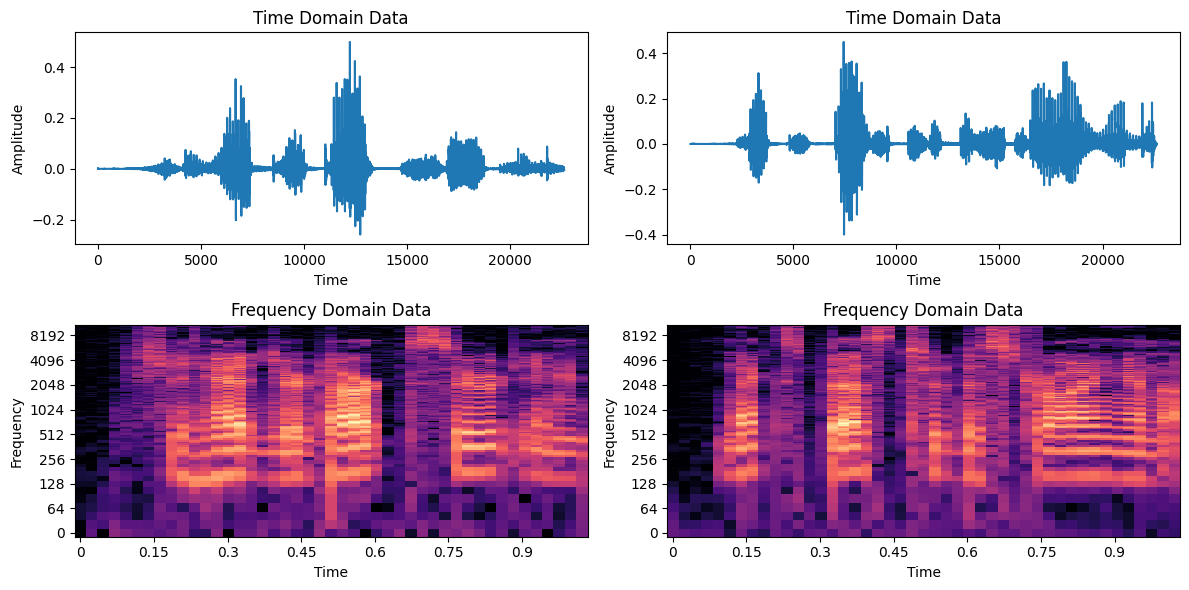

1/1 [==============================] - 0s 81ms/step
LSTM Model output for 1st positive sample  [[ 1.40576363e-01  4.77569997e-01 -2.70694792e-01 -1.84514597e-02
  -3.51107158e-02  6.86949166e-03 -1.50524199e-01  2.93835074e-01
  -1.49702743e-01 -1.99585095e-01  3.15222353e-01 -5.97763136e-02
   1.56857535e-01 -6.00682683e-02  3.04815710e-01 -2.77366936e-01
  -1.32962123e-01  1.56305850e-01  3.19127947e-01  3.07289839e-01
  -1.01129167e-01  2.94976924e-02 -4.05203402e-01  1.57158926e-01
  -1.59231693e-01  6.74483478e-02 -9.47053730e-02 -5.33273816e-01
  -2.98840106e-01  1.41178891e-01  2.84115583e-01 -6.37270212e-02
  -1.08053431e-01 -2.40498766e-01 -7.84783438e-02 -1.14481069e-01
   6.16396293e-02  4.40360904e-01  1.22707181e-01 -6.00551218e-02
  -8.12572166e-02 -2.54955292e-01  4.31520909e-01 -3.49464789e-02
  -2.92549759e-01  2.35932529e-01 -1.39940128e-01 -3.20916265e-01
  -2.47078255e-01  3.10138464e-01 -3.74711990e-01  2.54458964e-01
   2.24667519e-01  3.99619311e-01  1.16804986e-

In [16]:
ps_1_TD = test_data[0]
ps_2_TD = test_data[7]
ps_1_C_FD = librosa.stft(ps_1_TD, n_fft=1024, hop_length=512)
ps_2_C_FD = librosa.stft(ps_2_TD, n_fft=1024, hop_length=512)
ps_1_FD = np.abs(ps_1_C_FD)
ps_2_FD = np.abs(ps_2_C_FD)

plt.figure(figsize=(12, 6))

# Plot time domain data
plt.subplot(2, 2, 1)
plt.plot(ps_1_TD)
plt.title('Time Domain Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(ps_2_TD)
plt.title('Time Domain Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot frequency domain data
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(ps_1_FD, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(ps_2_FD, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

embedding_a = model.predict(ps_1_FD.T.reshape((1, 45, 513)))
embedding_b = model.predict(ps_2_FD.T.reshape((1, 45, 513)))
inner_product = Dot(axes=1, normalize=True)([embedding_a, embedding_b])
output = Dense(1, activation='sigmoid')(inner_product)

print('LSTM Model output for 1st positive sample ', embedding_a)
print('LSTM Model output for 2nd positive sample ', embedding_b)
print('Inner product of output of LSTM for the positive sample ', inner_product)
print('Sigmoid activation for positive sample ', output)



#### Negative Samples

In [17]:
Audio(data=test_data[75], rate = 16000)

In [18]:
Audio(data=test_data[85], rate = 16000)

C:\Users\anant\AppData\Local\Temp\ipykernel_11432\2786049786.py:31: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(ns_2_C_FD, ref=np.max), y_axis='log', x_axis='time')


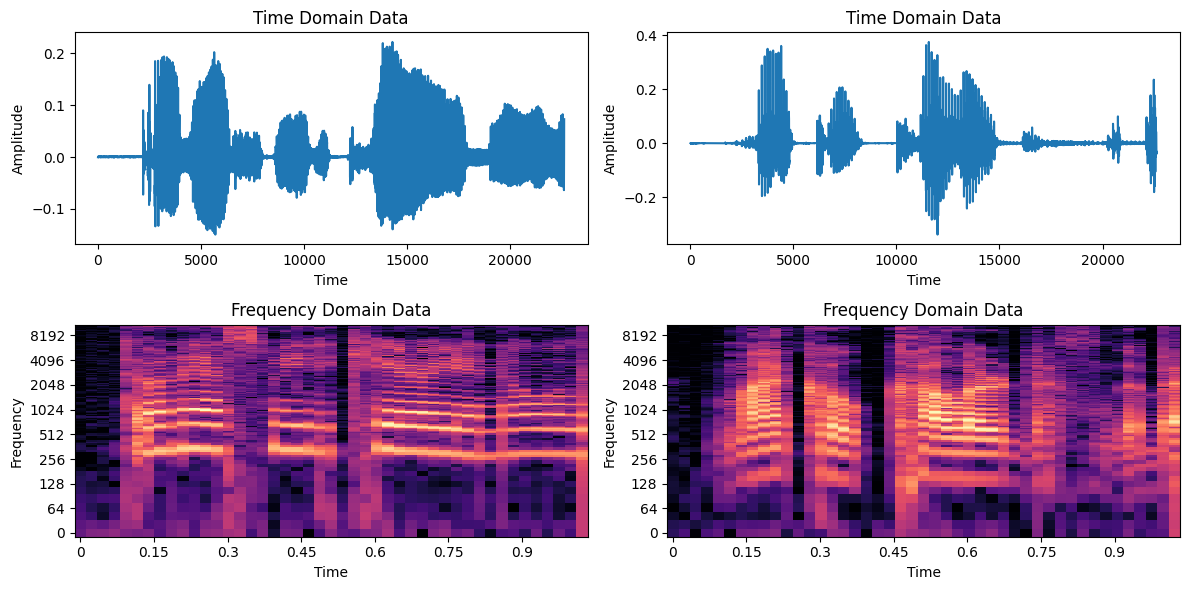

1/1 [==============================] - 0s 59ms/step
LSTM Model output for 1st negative sample  [[ 0.27568382 -0.21467182  0.44170168  0.45488033  0.13084467  0.4703486
   0.30433124 -0.3989325   0.52213895 -0.28738242 -0.06155026 -0.17603858
  -0.14543317 -0.136221    0.35221124  0.64111793 -0.5238278  -0.24450177
  -0.55461776  0.1038213  -0.07745487 -0.5784493   0.00251831 -0.27546063
   0.4350486  -0.12552676  0.02332724  0.12928177 -0.05228478 -0.61235934
  -0.4272159  -0.00789033  0.02179313  0.63458127  0.24505952  0.6151034
   0.27053875 -0.55099404 -0.1432319  -0.5014361  -0.12629989  0.3401696
   0.33324912  0.81521785 -0.08881664 -0.06454371 -0.644581    0.35249177
   0.6361727  -0.41897878 -0.09375734 -0.15502574 -0.51693773 -0.41942406
   0.34590486  0.72822595  0.4469354   0.01024429  0.40762022 -0.13080034
  -0.24239977  0.37400013  0.62321913 -0.1144404 ]]
LSTM Model output for 2nd negative sample  [[ 0.41372448 -0.11234634 -0.2898597  -0.35847476 -0.23037036  0.11848645

In [19]:
ns_1_TD = test_data[75]
ns_2_TD = test_data[85]
ns_1_C_FD = librosa.stft(ns_1_TD, n_fft=1024, hop_length=512)
ns_2_C_FD = librosa.stft(ns_2_TD, n_fft=1024, hop_length=512)
ns_1_FD = np.abs(ns_1_C_FD)
ns_2_FD = np.abs(ns_2_C_FD)

plt.figure(figsize=(12, 6))

# Plot time domain data
plt.subplot(2, 2, 1)
plt.plot(ns_1_TD)
plt.title('Time Domain Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(ns_2_TD)
plt.title('Time Domain Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot frequency domain data
plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(ns_1_FD, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.amplitude_to_db(ns_2_C_FD, ref=np.max), y_axis='log', x_axis='time')
plt.title('Frequency Domain Data')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

embedding_a = model.predict(ns_1_FD.T.reshape((1, 45, 513)))
embedding_b = model.predict(ns_2_FD.T.reshape((1, 45, 513)))
inner_product = Dot(axes=1, normalize=True)([embedding_a, embedding_b])
output = Dense(1, activation='sigmoid')(inner_product)

print('LSTM Model output for 1st negative sample ', embedding_a)
print('LSTM Model output for 2nd negative sample ', embedding_b)
print('Inner product of output of LSTM for the negative sample ', inner_product)
print('Sigmoid activation for negative sample ', output)